In [2]:
# set up:
%matplotlib inline
import random
import matplotlib.pylab as plt

from PIL import Image
import numpy as np
from scipy.misc import imresize
import glob

import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# preprocess images

# squash all images to size (512,512)
# adapted from https://github.com/ostegm/resizing/blob/master/Resizing.ipynb
size = 512
dpath = './chest_xray/'
X = {'train': [], 'val': [], 'test': []}
y = {'train': [], 'val': [], 'test': []}
tot_num_file = 0
count_3d = 0
for data_group in ['test', 'val', 'train']:
    for classified in ['NORMAL', 'PNEUMONIA']: 
        fnames = list(glob.iglob(dpath + f'{data_group}/{classified}/*.jpeg'))
        tot_num_file += len(fnames)
        for fname in fnames:
            img = Image.open(fname)
            img_arr = np.array(img)
            if len(img_arr.shape) == 3:
                count_3d += 1
print('percentage of 3d images: ', count_3d/tot_num_file)

percentage of 3d images:  0.048326502732240435


Because few images are 3d so we'll keep everything 3d (size (512,512,1))

In [17]:
size = 512
dpath = './chest_xray/'
X = {'train': [], 'val': [], 'test': []}
y = {'train': [], 'val': [], 'test': []}
for data_group in ['test', 'val', 'train']:
    for classified in ['NORMAL', 'PNEUMONIA']: 
        fnames = list(glob.iglob(dpath + f'{data_group}/{classified}/*.jpeg'))
        for fname in fnames:
            img = Image.open(fname).convert("L")
            img_arr = np.array(img)
            resized = imresize(img_arr, (size, size))
            resized = resized[..., None]
            _y = 0 if classified == 'NORMAL' else 1
            y[data_group].append(_y)
            X[data_group].append(resized)
            
# shuffle data
# for data_group in X.keys():
#     combined = list(zip(X[data_group], y[data_group]))
#     random.shuffle(combined)
#     X[data_group][:], y[data_group][:] = zip(*combined)
X_train, y_train = np.stack(X['train'], axis=0), np.stack(y['train'], axis=0)
X_val, y_val = np.stack(X['val'], axis=0), np.stack(y['val'], axis=0)
X_test, y_test = np.stack(X['test'], axis=0), np.stack(y['test'], axis=0)

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


Train data shape:  (5216, 512, 512, 1)
Train labels shape:  (5216,)
Validation data shape:  (16, 512, 512, 1)
Validation labels shape:  (16,)
Test data shape:  (624, 512, 512, 1)
Test labels shape:  (624,)


[1 1 0 1 1 0 1 1 1 1]


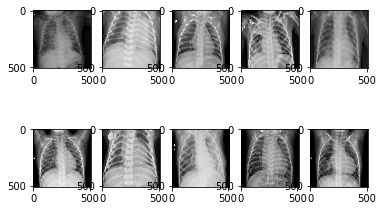

In [33]:
# display some random images
img_idx = np.random.randint(0, X_train.shape[0], 10)
for i, img in enumerate(X_train[img_idx,:,:,:]):
    img = np.reshape(img, (size, size))
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
print(y_train[img_idx])

It looks like that class '1' is much more frequent in the distribution of training classes. Let us visualize this:

(array([1341.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3875.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

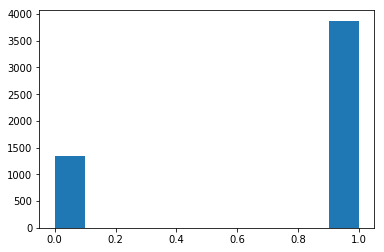

In [34]:
plt.hist(y_train)

Assume that this is a good approximate to the true distribution of pneunomia status classified from the Xray images, then we see a highly imbalanced data set (~4000:1500 ~ 5:2). If the imbalance is in the other direction (too many negatives and too few positives), we would definitelt have a problem, as we want high recall but the model could predict all negatives to get high accuracy and the recall terribly suffers. In this case, it is unclear whether or not the present imbalance is acceptable or not. This notebook is sort of an experiment to test whether balancing the class distribution would yield any improvement in this case. To do this, we will train on two training data sets, one balanced and the other not. We will create the balanced dataset by augmenting more images to the negative (0) class. There are some tactics available to augment data including flipping, rorating, scaling, cropping, translating, noise adding. We don't want to introduce to the images in the current negative class any radically new feature that does not exist in the other class. For example, if we choose to flip every negative-class image, then we have in the negative class a set of images that have the right and left parts of the bodies switched while the other class does not have this feature. This is not desirable because, the network may learn uneccesary (and incorrect) features such as the image with the left part of the body being to a certain side is more likely to exhibit non-pneumonia. The safest bet is to just scaling (cropping a little then resizing to the original size) the images.

In [36]:
fnames = list(glob.iglob(dpath + f'train/NORMAL/*.jpeg'))
y_cropped, X_cropped = [], []
for fname in fnames:
    img = Image.open(fname).convert("L")
    crop_specs = (4, 4, img.width - 4, img.height - 4)
    # crops thumbnail 4 pixels in from the left, top, right, and bottom
    crop_img = img.crop(crop_specs)
    img_arr = np.array(crop_img)
    # resizing to (512, 512)
    resized = imresize(img_arr, (size, size))
    resized = resized[..., None]
    y_cropped.append(0)
    X_cropped.append(resized)

X_cropped, y_cropped = np.stack(X_cropped, axis=0), np.stack(y_cropped, axis=0)

print('Train Normal cropped data shape: ', X_cropped.shape)
print('Train Normal cropped labels shape: ', y_cropped.shape)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


Train Normal cropped data shape:  (1341, 512, 512, 1)
Train Normal cropped labels shape:  (1341,)


[0 0 0 0 0 0 0 0 0 0]


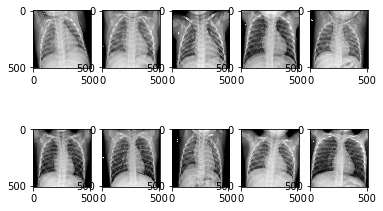

In [37]:
# display some random images
img_idx = np.random.randint(0, X_cropped.shape[0], 10)
for i, img in enumerate(X_cropped[img_idx,:,:,:]):
    img = np.reshape(img, (size, size))
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
print(y_cropped[img_idx])

In [53]:
X_train_cropped = np.vstack((X_train, X_cropped))
y_train_cropped = np.hstack((y_train, y_cropped))

print('Balanced trained data shape: ', X_train_cropped.shape)
print('Balanced labels shape: ', y_train_cropped.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)

Balanced trained data shape:  (6557, 512, 512, 1)
Balanced labels shape:  (6557,)
Train data shape:  (5216, 512, 512, 1)
Train labels shape:  (5216,)


Now we can augment the data for BOTH classes in the training set. We can do this by cropping and resizing exactly like what we did above, and flipping.

In [54]:
for classified in ['NORMAL', 'PNEUMONIA']: 
    fnames = list(glob.iglob(dpath + f'train/{classified}/*.jpeg'))
    y_cropped, X_cropped = [], []
    for fname in fnames:
        img = Image.open(fname).convert("L")
        for crop_size in [1, 3, 5, 7]:
            crop_specs = (crop_size, crop_size, 
                          img.width - crop_size, img.height - crop_size)
            # crops thumbnail 4 pixels in from the left, top, right, and bottom
            crop_img = img.crop(crop_specs)
            img_arr = np.array(crop_img)
            # resizing to (512, 512)
            resized = imresize(img_arr, (size, size))
            resized = resized[..., None]
            _y = 0 if classified == 'NORMAL' else 1
            y_cropped.append(_y)
            X_cropped.append(resized)

X_cropped, y_cropped = np.stack(X_cropped, axis=0), np.stack(y_cropped, axis=0)

print('Train Normal cropped data shape: ', X_cropped.shape)
print('Train Normal cropped labels shape: ', y_cropped.shape)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]


Train Normal cropped data shape:  (15500, 512, 512, 1)
Train Normal cropped labels shape:  (15500,)


In [55]:
X_train = np.vstack((X_train, X_cropped))
y_train = np.hstack((y_train, y_cropped))
X_train_balanced = np.vstack((X_train_cropped, X_cropped))
y_train_balanced = np.hstack((y_train_cropped, y_cropped))

print('Balanced train data shape: ', X_train_balanced.shape)
print('Balanced labels shape: ', y_train_balanced.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)

Balanced train data shape:  (22057, 512, 512, 1)
Balanced labels shape:  (22057,)
Train data shape:  (20716, 512, 512, 1)
Train labels shape:  (20716,)


# Model 



In [3]:
from models.research.slim.datasets import dataset_utils

url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading inception_v1_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v1_2016_08_28.tar.gz 24642554 bytes.


In [28]:
L = [1e-5, 1e-3, 1e-2]
decay_steps = 1000
decay_rate = 0.8
for dropout_strength in [.4, .6, .8, .9]:
    for reg in L:
        for starter_learning_rate in L:
            def my_model(X,y,is_training):
                Wconv1 = tf.get_variable("Wconv1", shape=[2, 2, 1, 10])
                bconv1 = tf.get_variable("bconv1", shape=[10])
                betabatch1 = tf.get_variable("betabatch", shape = [10])
                gammabatch1 = tf.get_variable("gammabatch", shape = [10])

                Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 10, 60])
                bconv2 = tf.get_variable("bconv2", shape=[60])
                betabatch2 = tf.get_variable("betabatch2", shape = [60])
                gammabatch2 = tf.get_variable("gammabatch2", shape = [60])

                Wconv3 = tf.get_variable("Wconv3", shape=[5, 5, 60, 70])
                bconv3 = tf.get_variable("bconv3", shape=[70])

                Wconv4 = tf.get_variable("Wconv4", shape=[5, 5, 70, 50])
                bconv4 = tf.get_variable("bconv4", shape=[50])

                Wconv5 = tf.get_variable("Wconv5", shape=[4, 4, 50, 50])
                bconv5 = tf.get_variable("bconv5", shape=[50])
                
                Wconv6 = tf.get_variable("Wconv6", shape=[3, 3, 50, 50])
                bconv6 = tf.get_variable("bconv6", shape=[50])
                
                Wconv7 = tf.get_variable("Wconv7", shape=[4, 4, 50, 50])
                bconv7 = tf.get_variable("bconv7", shape=[50])


                W8 = tf.get_variable("W8", shape=[8*8*50, 100])
                b8 = tf.get_variable("b8", shape=[100])
                W9 = tf.get_variable("W9", shape=[100,2])
                b9 = tf.get_variable("b9", shape=[2])
#                 W8 = tf.get_variable("W8", shape=[900,1000])
#                 b8 = tf.get_variable("b8", shape=[1000])

                ### CONV1 ###

                conv1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
                relu1 = tf.nn.relu(conv1)
                relu1 = tf.nn.dropout(relu1, dropout_strength)
                mpool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID' )
                meanbatch1, variancebatch1 = tf.nn.moments(mpool1, axes = [0,1,2], keep_dims=True)
                norm1 = tf.nn.batch_normalization(mpool1, meanbatch1, variancebatch1, betabatch1, gammabatch1, 1e-5)

                ### CONV2 ###

                conv2 = tf.nn.conv2d(norm1, Wconv2, strides=[1,1,1,1], padding='SAME') + bconv2
                relu2 = tf.nn.relu(conv2)
                relu2 = tf.nn.dropout(relu2, dropout_strength)
                mpool2 = tf.nn.max_pool(relu2, ksize=[1, 4, 4, 1], strides=[1, 1, 1, 1], padding='VALID' )
                meanbatch2, variancebatch2 = tf.nn.moments(mpool2, axes = [0,1,2], keep_dims=True)
                norm2 = tf.nn.batch_normalization(mpool2, meanbatch2, variancebatch2, betabatch2, gammabatch2, 1e-5)

                ### CONV3 ###
                # Padding
            #     paddings = tf.constant()
            #     norm2 = tf.pad(norm2, paddings, "CONSTANT")
                norm2 = tf.image.resize_image_with_crop_or_pad(
                norm2,
                509,
                509
            )
                conv3 = tf.nn.conv2d(norm2, Wconv3, strides=[1,2,2,1], padding='VALID') + bconv3
                conv4 = tf.nn.conv2d(conv3, Wconv4, strides=[1,2,2,1], padding='VALID') + bconv4
                conv5 = tf.nn.conv2d(conv4, Wconv5, strides=[1,2,2,1], padding='VALID') + bconv5
                conv6 = tf.nn.conv2d(conv5, Wconv6, strides=[1,2,2,1], padding='VALID') + bconv6
                mpool3 = tf.nn.max_pool(conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID' )

                ### FC6, FC7, FC8 ###
                mpool3_flat = tf.reshape(mpool3,[-1,8*8*50])
                fc8 = tf.matmul(mpool3_flat,W8) + b8
                y_out = tf.matmul(fc8,W9) + b9
#                 # y_out = tf.matmul(fc7,W8) + b8
                regularizers = (tf.nn.l2_loss(Wconv1) + tf.nn.l2_loss(Wconv2) +\
                                tf.nn.l2_loss(Wconv3) +  tf.nn.l2_loss(Wconv4) +\
                                tf.nn.l2_loss(Wconv5) + tf.nn.l2_loss(Wconv6) +\
                                tf.nn.l2_loss(Wconv7) + tf.nn.l2_loss(W8) + tf.nn.l2_loss(W9))
                return y_out, regularizers
            # hyperparameters
#             reg = 1e-3
#             starter_learning_rate = 5e-2
#             decay_steps = 1000
#             decay_rate = 0.8
            tf.reset_default_graph()

            X = tf.placeholder(tf.float32, [None, 512, 512, 1])
            y = tf.placeholder(tf.int64, [None])
            is_training = tf.placeholder(tf.bool)

            y_out, regularizers = my_model(X,y,is_training)

            # loss function with L2 regularization
            total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,2),logits=y_out)
            mean_loss = tf.reduce_mean(total_loss)
            mean_loss = tf.reduce_mean(mean_loss + reg * regularizers)

            # define our optimizer

            global_step = tf.Variable(0, trainable=False)
            learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                                       decay_steps, decay_rate, staircase=True)
            optimizer = tf.train.AdamOptimizer(learning_rate) # select optimizer and set learning rate

            # batch normalization in tensorflow requires this extra dependency
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(extra_update_ops):
                train_step = optimizer.minimize(mean_loss)
                
            print('HYPERPARAMETERS: ', (dropout_strength, reg, starter_learning_rate, decay_steps, decay_rate))
            sess = tf.Session()

            sess.run(tf.global_variables_initializer())
            print('Training')
            run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
            print('Validation')
            run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

HYPERPARAMETERS:  (0.4, 1e-05, 1e-05, 1000, 0.8)
Training


InvalidArgumentError: logits and labels must be broadcastable: logits_size=[225,2] labels_size=[64,2]
	 [[Node: softmax_cross_entropy_loss/xentropy = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](add_7, softmax_cross_entropy_loss/xentropy/Reshape_1)]]

Caused by op 'softmax_cross_entropy_loss/xentropy', defined at:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-4dd11fde1de6>", line 98, in <module>
    total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,2),logits=y_out)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py", line 755, in softmax_cross_entropy
    labels=onehot_labels, logits=logits, name="xentropy")
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1879, in softmax_cross_entropy_with_logits_v2
    precise_logits, labels, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 7205, in softmax_cross_entropy_with_logits
    name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): logits and labels must be broadcastable: logits_size=[225,2] labels_size=[64,2]
	 [[Node: softmax_cross_entropy_loss/xentropy = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](add_7, softmax_cross_entropy_loss/xentropy/Reshape_1)]]


HYPERPARAMETERS:  (0.4, 1e-05, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 6.72 and accuracy of 0
Epoch 1, Overall loss = 2 and accuracy of 0.701


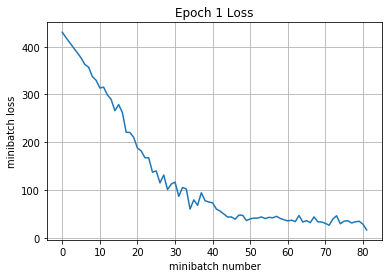

Validation
Epoch 1, Overall loss = 0.75 and accuracy of 0.5
HYPERPARAMETERS:  (0.4, 1e-05, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 6.91 and accuracy of 0
Epoch 1, Overall loss = 2.17 and accuracy of 0.72


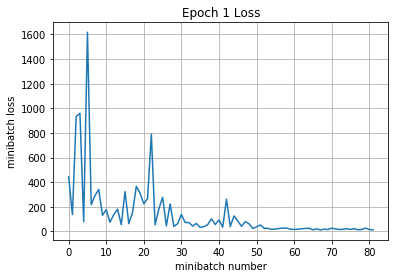

Validation
Epoch 1, Overall loss = 0.437 and accuracy of 0.75
HYPERPARAMETERS:  (0.4, 1e-05, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 6.99 and accuracy of 0
Epoch 1, Overall loss = 3.69e+04 and accuracy of 0.553


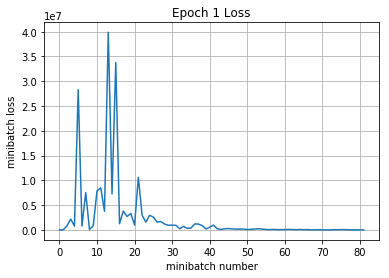

Validation
Epoch 1, Overall loss = 216 and accuracy of 0.5
HYPERPARAMETERS:  (0.4, 0.001, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.68 and accuracy of 0
Epoch 1, Overall loss = 3.85 and accuracy of 0.71


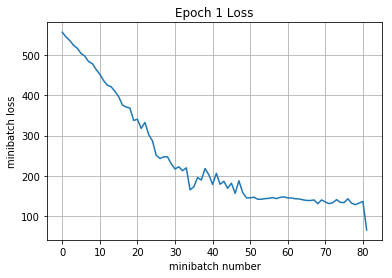

Validation
Epoch 1, Overall loss = 2.5 and accuracy of 0.5
HYPERPARAMETERS:  (0.4, 0.001, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.31 and accuracy of 0
Epoch 1, Overall loss = 2.48 and accuracy of 0.756


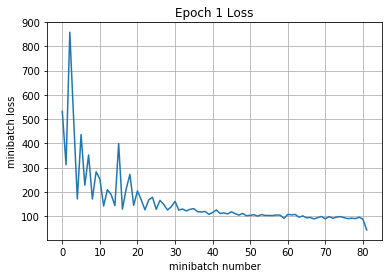

Validation
Epoch 1, Overall loss = 2.09 and accuracy of 0.625
HYPERPARAMETERS:  (0.4, 0.001, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.82 and accuracy of 0
Epoch 1, Overall loss = 2.29e+04 and accuracy of 0.638


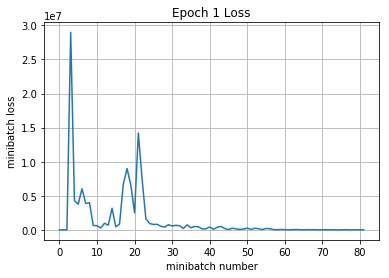

Validation
Epoch 1, Overall loss = 1.49e+03 and accuracy of 0.562
HYPERPARAMETERS:  (0.4, 0.01, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.8 and accuracy of 0
Epoch 1, Overall loss = 18.7 and accuracy of 0.695


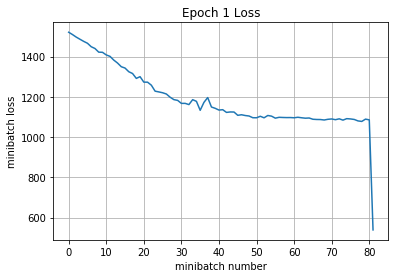

Validation
Epoch 1, Overall loss = 17.2 and accuracy of 0.5
HYPERPARAMETERS:  (0.4, 0.01, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.8 and accuracy of 0
Epoch 1, Overall loss = 12.4 and accuracy of 0.707


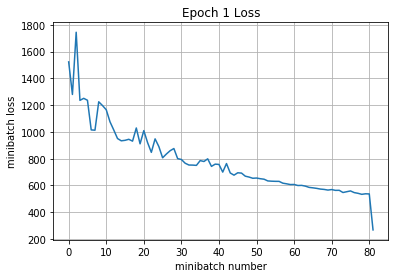

Validation
Epoch 1, Overall loss = 8.55 and accuracy of 0.75
HYPERPARAMETERS:  (0.4, 0.01, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.6 and accuracy of 0
Epoch 1, Overall loss = 1.33e+04 and accuracy of 0.561


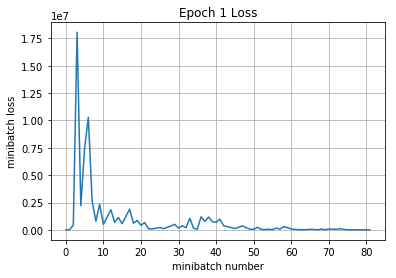

Validation
Epoch 1, Overall loss = 256 and accuracy of 0.625
HYPERPARAMETERS:  (0.6, 1e-05, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 7.07 and accuracy of 0
Epoch 1, Overall loss = 2.24 and accuracy of 0.694


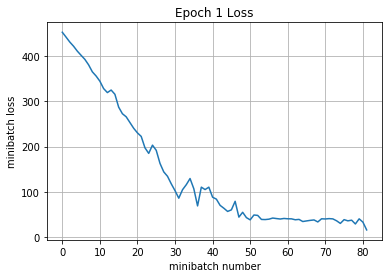

Validation
Epoch 1, Overall loss = 0.724 and accuracy of 0.562
HYPERPARAMETERS:  (0.6, 1e-05, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 6.81 and accuracy of 0
Epoch 1, Overall loss = 1.8 and accuracy of 0.713


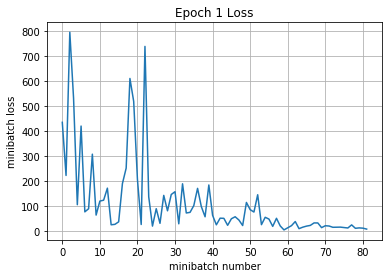

Validation
Epoch 1, Overall loss = 0.555 and accuracy of 0.875
HYPERPARAMETERS:  (0.6, 1e-05, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 6.72 and accuracy of 0
Epoch 1, Overall loss = 4.95e+04 and accuracy of 0.496


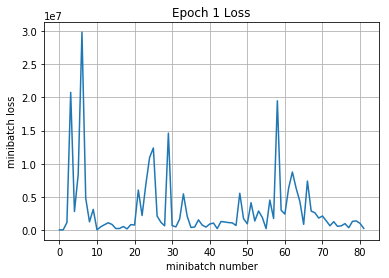

Validation
Epoch 1, Overall loss = 7.01e+03 and accuracy of 0.562
HYPERPARAMETERS:  (0.6, 0.001, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.73 and accuracy of 0
Epoch 1, Overall loss = 3.96 and accuracy of 0.696


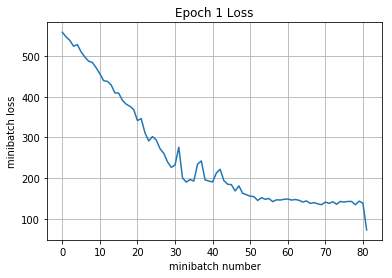

Validation
Epoch 1, Overall loss = 2.41 and accuracy of 0.562
HYPERPARAMETERS:  (0.6, 0.001, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.45 and accuracy of 0
Epoch 1, Overall loss = 2.81 and accuracy of 0.753


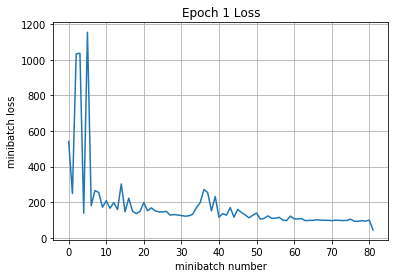

Validation
Epoch 1, Overall loss = 1.75 and accuracy of 0.75
HYPERPARAMETERS:  (0.6, 0.001, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.89 and accuracy of 0
Epoch 1, Overall loss = 4.76e+04 and accuracy of 0.535


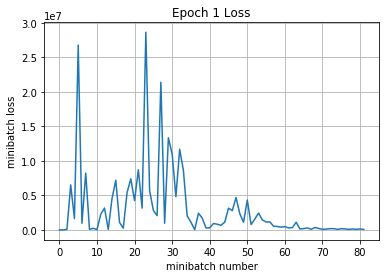

Validation
Epoch 1, Overall loss = 1.97e+03 and accuracy of 0.5
HYPERPARAMETERS:  (0.6, 0.01, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.5 and accuracy of 0
Epoch 1, Overall loss = 18.5 and accuracy of 0.705


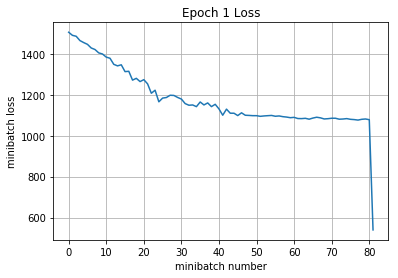

Validation
Epoch 1, Overall loss = 17 and accuracy of 0.562
HYPERPARAMETERS:  (0.6, 0.01, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.5 and accuracy of 0
Epoch 1, Overall loss = 13.1 and accuracy of 0.736


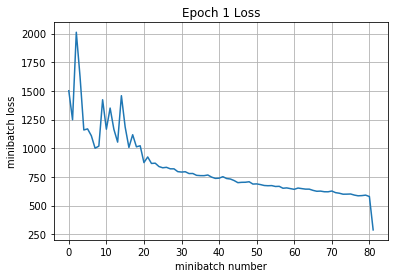

Validation
Epoch 1, Overall loss = 9.26 and accuracy of 0.812
HYPERPARAMETERS:  (0.6, 0.01, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.4 and accuracy of 0
Epoch 1, Overall loss = 3.43e+04 and accuracy of 0.563


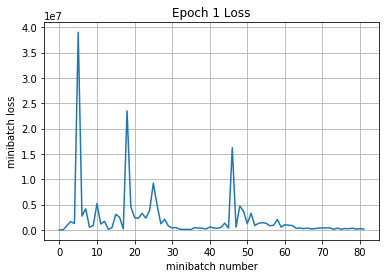

Validation
Epoch 1, Overall loss = 2.58e+03 and accuracy of 0.688
HYPERPARAMETERS:  (0.8, 1e-05, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 6.65 and accuracy of 0
Epoch 1, Overall loss = 2.06 and accuracy of 0.72


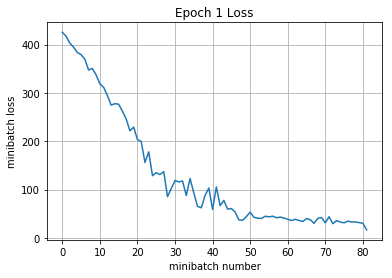

Validation
Epoch 1, Overall loss = 0.764 and accuracy of 0.5
HYPERPARAMETERS:  (0.8, 1e-05, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 6.85 and accuracy of 0
Epoch 1, Overall loss = 0.923 and accuracy of 0.836


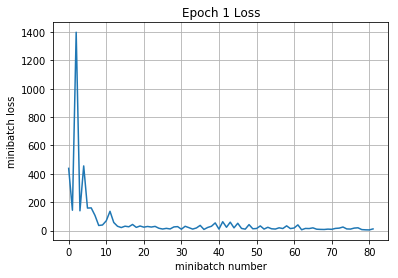

Validation
Epoch 1, Overall loss = 1.2 and accuracy of 0.688
HYPERPARAMETERS:  (0.8, 1e-05, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 6.76 and accuracy of 0
Epoch 1, Overall loss = 1.89e+04 and accuracy of 0.637


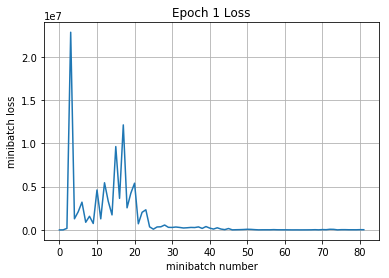

Validation
Epoch 1, Overall loss = 1.3e+03 and accuracy of 0.625
HYPERPARAMETERS:  (0.8, 0.001, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.22 and accuracy of 0
Epoch 1, Overall loss = 3.66 and accuracy of 0.728


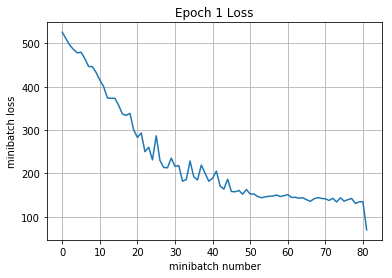

Validation
Epoch 1, Overall loss = 2.45 and accuracy of 0.5
HYPERPARAMETERS:  (0.8, 0.001, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.45 and accuracy of 0
Epoch 1, Overall loss = 2.58 and accuracy of 0.805


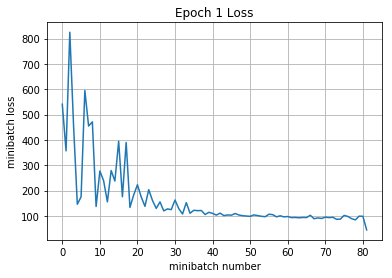

Validation
Epoch 1, Overall loss = 1.61 and accuracy of 0.875
HYPERPARAMETERS:  (0.8, 0.001, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.71 and accuracy of 0
Epoch 1, Overall loss = 3.91e+03 and accuracy of 0.584


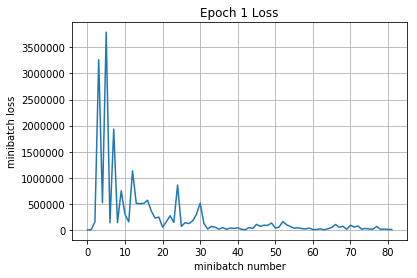

Validation
Epoch 1, Overall loss = 3.24e+03 and accuracy of 0.5
HYPERPARAMETERS:  (0.8, 0.01, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.6 and accuracy of 0
Epoch 1, Overall loss = 18.4 and accuracy of 0.728


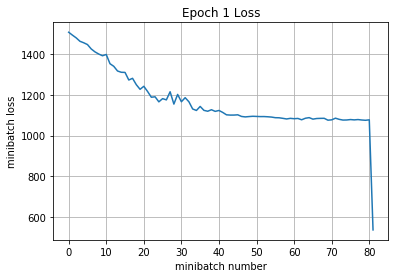

Validation
Epoch 1, Overall loss = 17 and accuracy of 0.562
HYPERPARAMETERS:  (0.8, 0.01, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.5 and accuracy of 0
Epoch 1, Overall loss = 11.7 and accuracy of 0.857


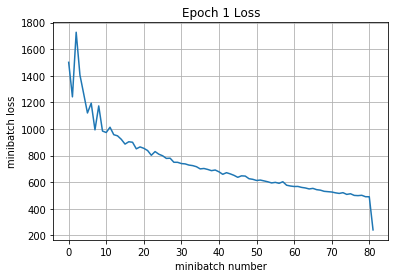

Validation
Epoch 1, Overall loss = 7.68 and accuracy of 0.875
HYPERPARAMETERS:  (0.8, 0.01, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.5 and accuracy of 0
Epoch 1, Overall loss = 3e+04 and accuracy of 0.56


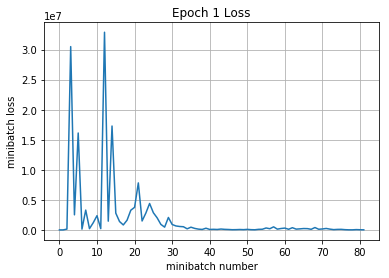

Validation
Epoch 1, Overall loss = 1.1e+03 and accuracy of 0.625
HYPERPARAMETERS:  (0.9, 1e-05, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 7.12 and accuracy of 0
Epoch 1, Overall loss = 2.29 and accuracy of 0.689


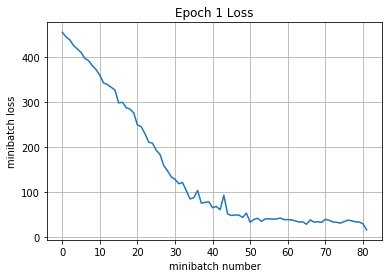

Validation
Epoch 1, Overall loss = 0.676 and accuracy of 0.5
HYPERPARAMETERS:  (0.9, 1e-05, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 6.98 and accuracy of 0
Epoch 1, Overall loss = 1.49 and accuracy of 0.761


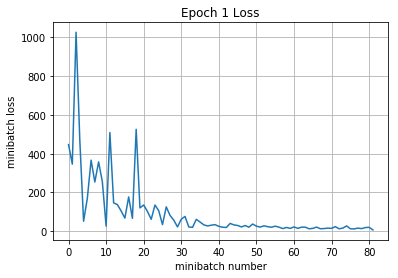

Validation
Epoch 1, Overall loss = 0.484 and accuracy of 0.812
HYPERPARAMETERS:  (0.9, 1e-05, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 6.87 and accuracy of 0
Epoch 1, Overall loss = 2.17e+04 and accuracy of 0.541


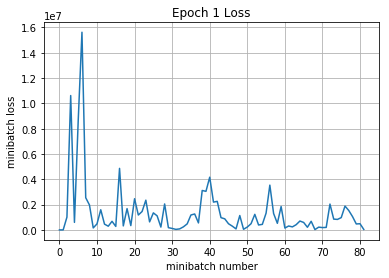

Validation
Epoch 1, Overall loss = 1.14e+04 and accuracy of 0.5
HYPERPARAMETERS:  (0.9, 0.001, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.79 and accuracy of 0
Epoch 1, Overall loss = 3.92 and accuracy of 0.682


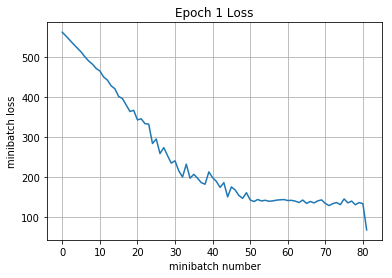

Validation
Epoch 1, Overall loss = 2.34 and accuracy of 0.625
HYPERPARAMETERS:  (0.9, 0.001, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.57 and accuracy of 0
Epoch 1, Overall loss = 3.48 and accuracy of 0.744


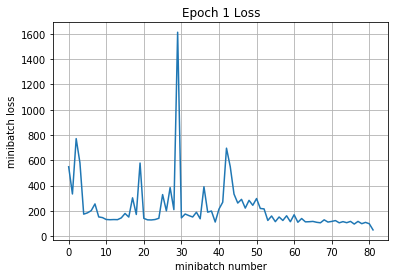

Validation
Epoch 1, Overall loss = 1.75 and accuracy of 0.875
HYPERPARAMETERS:  (0.9, 0.001, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 8.87 and accuracy of 0
Epoch 1, Overall loss = 5.93e+03 and accuracy of 0.582


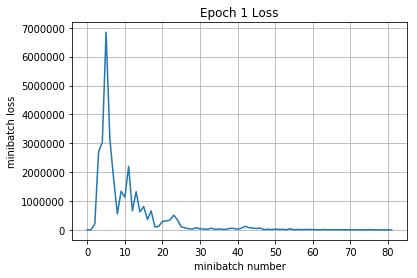

Validation
Epoch 1, Overall loss = 18.6 and accuracy of 0.688
HYPERPARAMETERS:  (0.9, 0.01, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.3 and accuracy of 0
Epoch 1, Overall loss = 18.4 and accuracy of 0.715


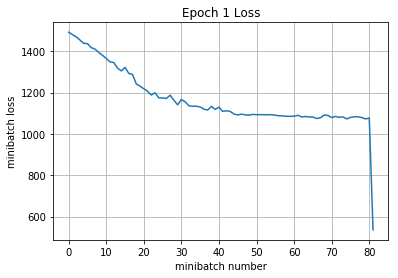

Validation
Epoch 1, Overall loss = 17.1 and accuracy of 0.562
HYPERPARAMETERS:  (0.9, 0.01, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 22.9 and accuracy of 0
Epoch 1, Overall loss = 12.8 and accuracy of 0.795


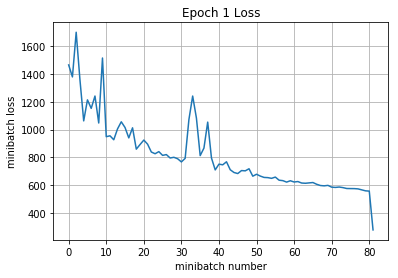

Validation
Epoch 1, Overall loss = 9.28 and accuracy of 0.688
HYPERPARAMETERS:  (0.9, 0.01, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 23.6 and accuracy of 0
Epoch 1, Overall loss = 1.54e+04 and accuracy of 0.632


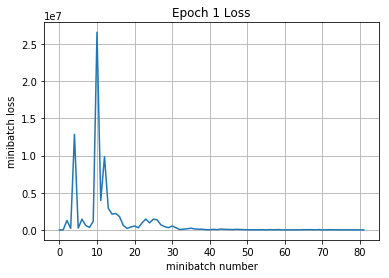

Validation
Epoch 1, Overall loss = 222 and accuracy of 0.688


In [31]:
L = [1e-5, 1e-3, 1e-2]
for dropout_strength in [.4, .6, .8, .9]:
    for reg in L:
        for starter_learning_rate in L:
            def my_model(X,y,is_training):
    #hyperparameters


                Wconv1 = tf.get_variable("Wconv1", shape=[2, 2, 1, 10])
                bconv1 = tf.get_variable("bconv1", shape=[10])
                betabatch1 = tf.get_variable("betabatch", shape = [10])
                gammabatch1 = tf.get_variable("gammabatch", shape = [10])

                Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 10, 60])
                bconv2 = tf.get_variable("bconv2", shape=[60])
                betabatch2 = tf.get_variable("betabatch2", shape = [60])
                gammabatch2 = tf.get_variable("gammabatch2", shape = [60])

                Wconv3 = tf.get_variable("Wconv3", shape=[5, 5, 60, 70])
                bconv3 = tf.get_variable("bconv3", shape=[70])

                Wconv4 = tf.get_variable("Wconv4", shape=[3, 3, 70, 80])
                bconv4 = tf.get_variable("bconv4", shape=[80])

                Wconv5 = tf.get_variable("Wconv5", shape=[3, 3, 80, 90])
                bconv5 = tf.get_variable("bconv5", shape=[90])


                W6 = tf.get_variable("W6", shape=[6*6*90, 800])
                b6 = tf.get_variable("b6", shape=[800])
                W7 = tf.get_variable("W7", shape=[800,900])
                b7 = tf.get_variable("b7", shape=[900])
                W8 = tf.get_variable("W8", shape=[900,1000])
                b8 = tf.get_variable("b8", shape=[1000])

                ### CONV1 ###

                conv1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
                relu1 = tf.nn.relu(conv1)
                relu1 = tf.nn.dropout(relu1, dropout_strength)
                mpool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID' )
                meanbatch1, variancebatch1 = tf.nn.moments(mpool1, axes = [0,1,2], keep_dims=True)
                norm1 = tf.nn.batch_normalization(mpool1, meanbatch1, variancebatch1, betabatch1, gammabatch1, 1e-5)

                ### CONV2 ###

                conv2 = tf.nn.conv2d(norm1, Wconv2, strides=[1,1,1,1], padding='SAME') + bconv2
                relu2 = tf.nn.relu(conv2)
                relu2 = tf.nn.dropout(relu2, dropout_strength)
                mpool2 = tf.nn.max_pool(relu2, ksize=[1, 4, 4, 1], strides=[1, 1, 1, 1], padding='VALID' )
                meanbatch2, variancebatch2 = tf.nn.moments(mpool2, axes = [0,1,2], keep_dims=True)
                norm2 = tf.nn.batch_normalization(mpool2, meanbatch2, variancebatch2, betabatch2, gammabatch2, 1e-5)

                ### CONV3 ###
                # Padding
            #     paddings = tf.constant()
            #     norm2 = tf.pad(norm2, paddings, "CONSTANT")
                norm2 = tf.image.resize_image_with_crop_or_pad(
                norm2,
                29,
                29
            )
                conv3 = tf.nn.conv2d(norm2, Wconv3, strides=[1,2,2,1], padding='VALID') + bconv3
                conv4 = tf.nn.conv2d(conv3, Wconv4, strides=[1,1,1,1], padding='SAME') + bconv4
                conv5 = tf.nn.conv2d(conv4, Wconv5, strides=[1,1,1,1], padding='SAME') + bconv5
                mpool3 = tf.nn.max_pool(conv5, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID' )

                ### FC6, FC7, FC8 ###
                mpool3_flat = tf.reshape(mpool3,[-1,6*6*90])
                fc6 = tf.matmul(mpool3_flat,W6) + b6
                fc7 = tf.matmul(fc6,W7) + b7
                y_out = tf.matmul(fc7,W8) + b8
                regularizers = (tf.nn.l2_loss(Wconv1) + tf.nn.l2_loss(Wconv2) + tf.nn.l2_loss(Wconv3) +  tf.nn.l2_loss(Wconv4) +\
                            tf.nn.l2_loss(Wconv5) + tf.nn.l2_loss(W6) + tf.nn.l2_loss(W7) + tf.nn.l2_loss(W8))
                return y_out, regularizers
            # hyperparameters
#             reg = 1e-3
#             starter_learning_rate = 5e-2
#             decay_steps = 1000
#             decay_rate = 0.8
            tf.reset_default_graph()

            X = tf.placeholder(tf.float32, [None, 32, 32, 1])
            y = tf.placeholder(tf.int64, [None])
            is_training = tf.placeholder(tf.bool)

            y_out, regularizers = my_model(X,y,is_training)

            # loss function with L2 regularization
            total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,1000),logits=y_out)
            mean_loss = tf.reduce_mean(total_loss)
            mean_loss = tf.reduce_mean(mean_loss + reg * regularizers)

            # define our optimizer

            global_step = tf.Variable(0, trainable=False)
            learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                                       decay_steps, decay_rate, staircase=True)
            optimizer = tf.train.AdamOptimizer(learning_rate) # select optimizer and set learning rate

            # batch normalization in tensorflow requires this extra dependency
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(extra_update_ops):
                train_step = optimizer.minimize(mean_loss)
                
            print('HYPERPARAMETERS: ', (dropout_strength, reg, starter_learning_rate, decay_steps, decay_rate))
            sess = tf.Session()

            sess.run(tf.global_variables_initializer())
            print('Training')
            run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
            print('Validation')
            run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
                
                
                
                

In [ ]:
(0.9, 0.001, 0.001, 1000, 0.8) 87.5 1.75
(0.9, 1e-05, 0.001, 1000, 0.8) 81.2, .484
(0.8, 0.01, 0.001, 1000, 0.8) 87.5 7.68
(0.8, 0.001, 0.001, 1000, 0.8) 87.5 1.61
(0.6, 0.01, 0.001, 1000, 0.8) 81.2 9.26
(0.6, 1e-05, 0.001, 1000, 0.8) 87.5 0.555

HYPERPARAMETERS:  (0.4, 1e-05, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 0.838 and accuracy of 0.28
Epoch 1, Overall loss = 0.521 and accuracy of 0.756


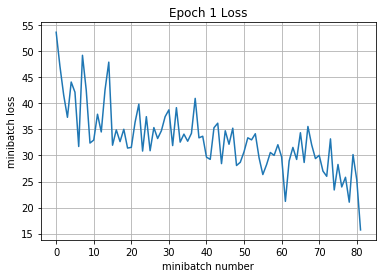

Validation
Epoch 1, Overall loss = 0.832 and accuracy of 0.5
HYPERPARAMETERS:  (0.4, 1e-05, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 1.2 and accuracy of 0.22
Epoch 1, Overall loss = 0.854 and accuracy of 0.797


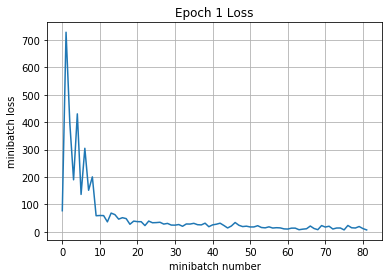

Validation
Epoch 1, Overall loss = 0.51 and accuracy of 0.875
HYPERPARAMETERS:  (0.4, 1e-05, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 1.27 and accuracy of 0.25
Epoch 1, Overall loss = 1.33e+04 and accuracy of 0.575


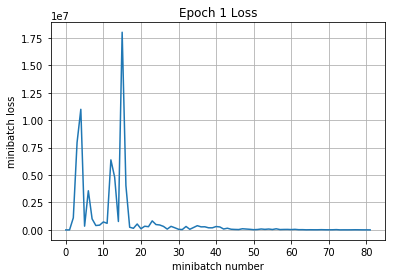

Validation
Epoch 1, Overall loss = 192 and accuracy of 0.562
HYPERPARAMETERS:  (0.4, 0.001, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 1.81 and accuracy of 0.72
Epoch 1, Overall loss = 1.71 and accuracy of 0.759


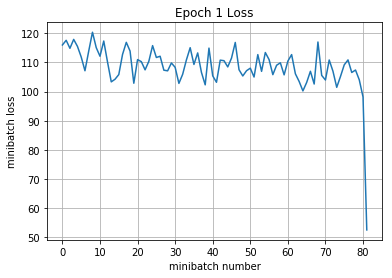

Validation
Epoch 1, Overall loss = 1.91 and accuracy of 0.625
HYPERPARAMETERS:  (0.4, 0.001, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 3.16 and accuracy of 0.2
Epoch 1, Overall loss = 2.12 and accuracy of 0.786


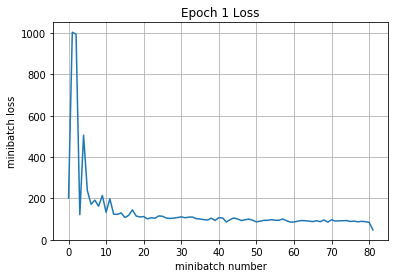

Validation
Epoch 1, Overall loss = 1.82 and accuracy of 0.812
HYPERPARAMETERS:  (0.4, 0.001, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 1.83 and accuracy of 0.75
Epoch 1, Overall loss = 6.58e+03 and accuracy of 0.679


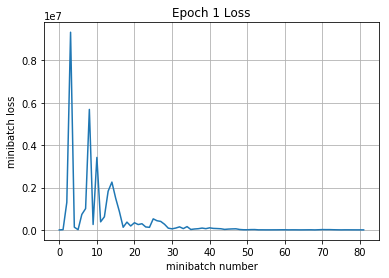

Validation
Epoch 1, Overall loss = 51.7 and accuracy of 0.562
HYPERPARAMETERS:  (0.4, 0.01, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 12.5 and accuracy of 0.81
Epoch 1, Overall loss = 12.3 and accuracy of 0.749


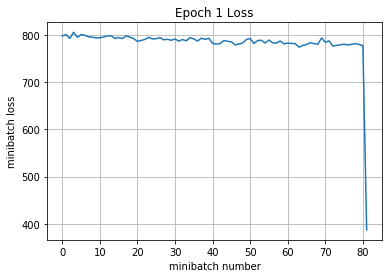

Validation
Epoch 1, Overall loss = 12.4 and accuracy of 0.5
HYPERPARAMETERS:  (0.4, 0.01, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 12.4 and accuracy of 0.75
Epoch 1, Overall loss = 9.88 and accuracy of 0.809


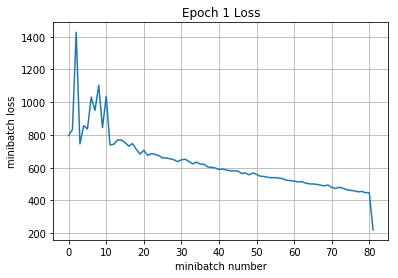

Validation
Epoch 1, Overall loss = 7.07 and accuracy of 0.812
HYPERPARAMETERS:  (0.4, 0.01, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 12.6 and accuracy of 0.69
Epoch 1, Overall loss = 7.1e+03 and accuracy of 0.607


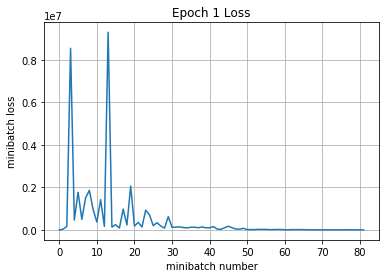

Validation
Epoch 1, Overall loss = 72.8 and accuracy of 0.562
HYPERPARAMETERS:  (0.6, 1e-05, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 0.676 and accuracy of 0.61
Epoch 1, Overall loss = 0.393 and accuracy of 0.824


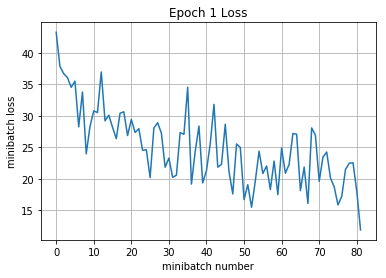

Validation
Epoch 1, Overall loss = 0.735 and accuracy of 0.688
HYPERPARAMETERS:  (0.6, 1e-05, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 0.916 and accuracy of 0.19
Epoch 1, Overall loss = 0.797 and accuracy of 0.831


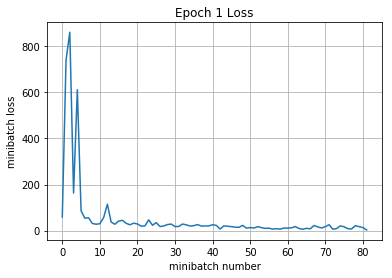

Validation
Epoch 1, Overall loss = 0.284 and accuracy of 0.938
HYPERPARAMETERS:  (0.6, 1e-05, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 1.25 and accuracy of 0.2
Epoch 1, Overall loss = 5.79e+03 and accuracy of 0.664


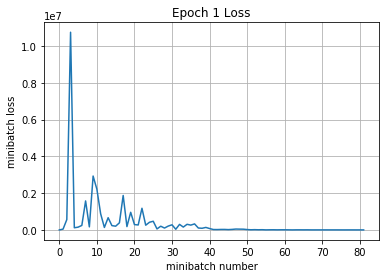

Validation
Epoch 1, Overall loss = 103 and accuracy of 0.688
HYPERPARAMETERS:  (0.6, 0.001, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 2.29 and accuracy of 0.25
Epoch 1, Overall loss = 1.69 and accuracy of 0.75


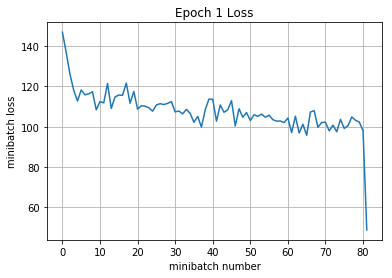

Validation
Epoch 1, Overall loss = 1.81 and accuracy of 0.562
HYPERPARAMETERS:  (0.6, 0.001, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 1.88 and accuracy of 0.62
Epoch 1, Overall loss = 1.83 and accuracy of 0.838


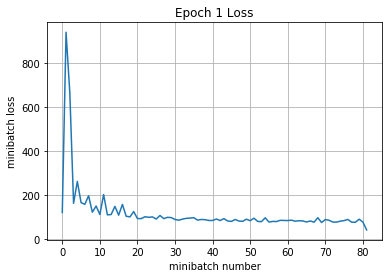

Validation
Epoch 1, Overall loss = 1.64 and accuracy of 0.812
HYPERPARAMETERS:  (0.6, 0.001, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 1.84 and accuracy of 0.67
Epoch 1, Overall loss = 1.14e+04 and accuracy of 0.609


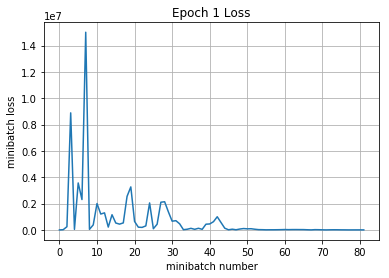

Validation
Epoch 1, Overall loss = 23.1 and accuracy of 0.688
HYPERPARAMETERS:  (0.6, 0.01, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 13.2 and accuracy of 0.2
Epoch 1, Overall loss = 12.3 and accuracy of 0.729


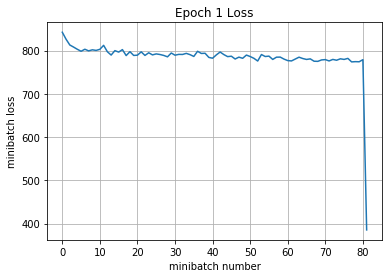

Validation
Epoch 1, Overall loss = 12.4 and accuracy of 0.562
HYPERPARAMETERS:  (0.6, 0.01, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 12.7 and accuracy of 0.31
Epoch 1, Overall loss = 10.3 and accuracy of 0.853


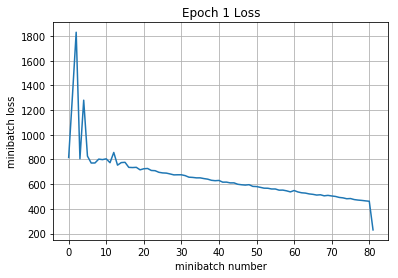

Validation
Epoch 1, Overall loss = 7.89 and accuracy of 0.5
HYPERPARAMETERS:  (0.6, 0.01, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 12.5 and accuracy of 0.66
Epoch 1, Overall loss = 4.69e+03 and accuracy of 0.678


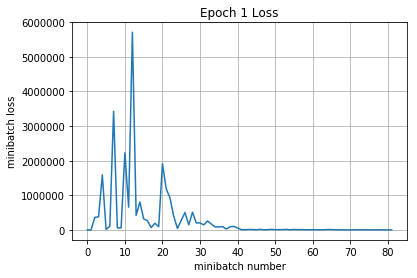

Validation
Epoch 1, Overall loss = 37.4 and accuracy of 0.875
HYPERPARAMETERS:  (0.8, 1e-05, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 0.766 and accuracy of 0.31
Epoch 1, Overall loss = 0.503 and accuracy of 0.77


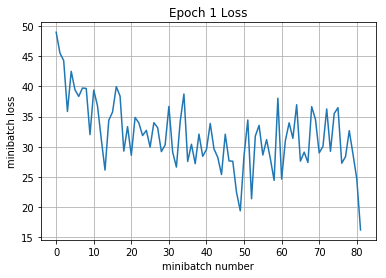

Validation
Epoch 1, Overall loss = 0.641 and accuracy of 0.625
HYPERPARAMETERS:  (0.8, 1e-05, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 0.766 and accuracy of 0.22
Epoch 1, Overall loss = 0.87 and accuracy of 0.838


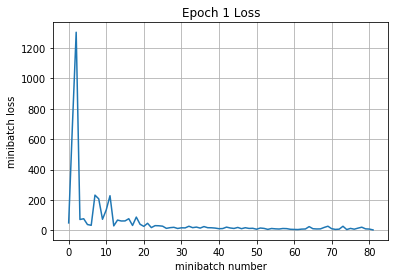

Validation
Epoch 1, Overall loss = 0.816 and accuracy of 0.562
HYPERPARAMETERS:  (0.8, 1e-05, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 1.41 and accuracy of 0.27
Epoch 1, Overall loss = 3.22e+03 and accuracy of 0.739


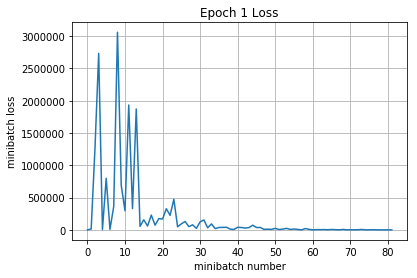

Validation
Epoch 1, Overall loss = 26.3 and accuracy of 0.75
HYPERPARAMETERS:  (0.8, 0.001, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 2.24 and accuracy of 0.3
Epoch 1, Overall loss = 1.67 and accuracy of 0.756


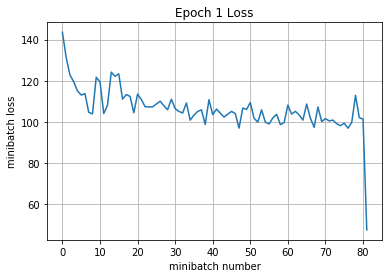

Validation
Epoch 1, Overall loss = 1.91 and accuracy of 0.562
HYPERPARAMETERS:  (0.8, 0.001, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 1.71 and accuracy of 0.81
Epoch 1, Overall loss = 1.98 and accuracy of 0.82


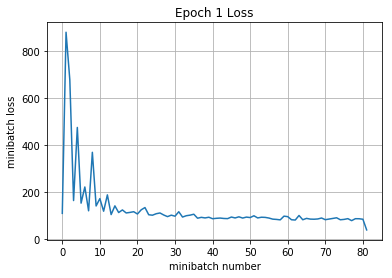

Validation
Epoch 1, Overall loss = 1.57 and accuracy of 0.75
HYPERPARAMETERS:  (0.8, 0.001, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 2.03 and accuracy of 0.25
Epoch 1, Overall loss = 1.51e+04 and accuracy of 0.636


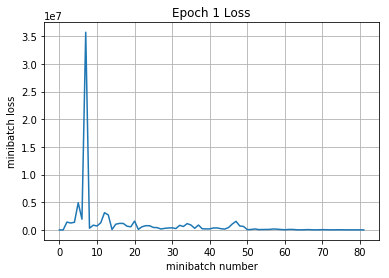

Validation
Epoch 1, Overall loss = 126 and accuracy of 0.5
HYPERPARAMETERS:  (0.8, 0.01, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 12.5 and accuracy of 0.8
Epoch 1, Overall loss = 12.2 and accuracy of 0.811


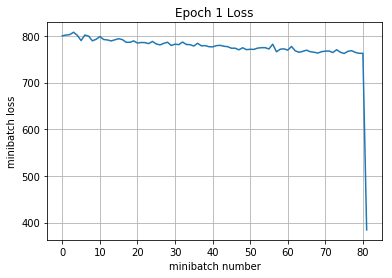

Validation
Epoch 1, Overall loss = 12.1 and accuracy of 0.75
HYPERPARAMETERS:  (0.8, 0.01, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 13 and accuracy of 0.3
Epoch 1, Overall loss = 11.2 and accuracy of 0.826


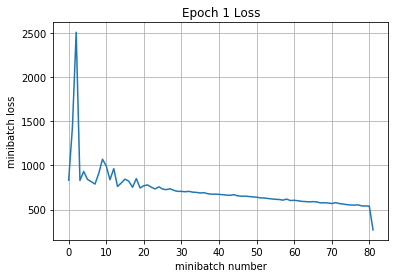

Validation
Epoch 1, Overall loss = 9.04 and accuracy of 0.562
HYPERPARAMETERS:  (0.8, 0.01, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 13.2 and accuracy of 0.23
Epoch 1, Overall loss = 1.11e+04 and accuracy of 0.632


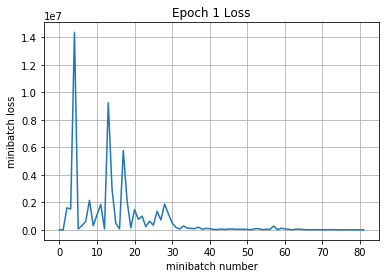

Validation
Epoch 1, Overall loss = 103 and accuracy of 0.625
HYPERPARAMETERS:  (0.9, 1e-05, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 0.716 and accuracy of 0.48
Epoch 1, Overall loss = 0.423 and accuracy of 0.807


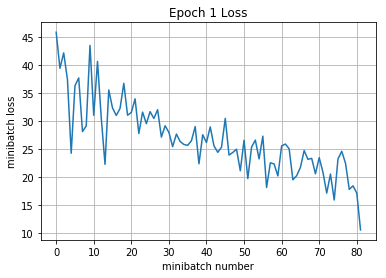

Validation
Epoch 1, Overall loss = 0.734 and accuracy of 0.625
HYPERPARAMETERS:  (0.9, 1e-05, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 0.6 and accuracy of 0.78
Epoch 1, Overall loss = 0.794 and accuracy of 0.853


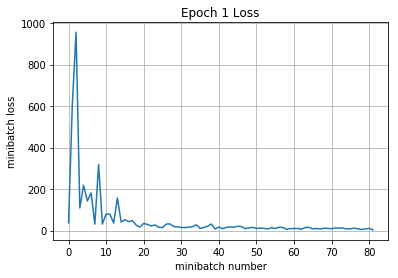

Validation
Epoch 1, Overall loss = 0.256 and accuracy of 0.875
HYPERPARAMETERS:  (0.9, 1e-05, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 0.528 and accuracy of 0.81
Epoch 1, Overall loss = 8.51e+03 and accuracy of 0.717


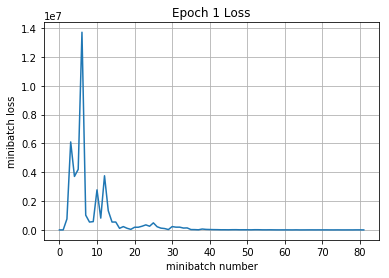

Validation
Epoch 1, Overall loss = 42.4 and accuracy of 0.688
HYPERPARAMETERS:  (0.9, 0.001, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 1.79 and accuracy of 0.77
Epoch 1, Overall loss = 1.57 and accuracy of 0.818


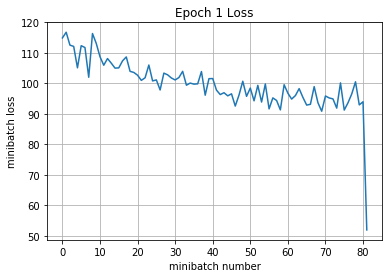

Validation
Epoch 1, Overall loss = 1.87 and accuracy of 0.625
HYPERPARAMETERS:  (0.9, 0.001, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 1.97 and accuracy of 0.34
Epoch 1, Overall loss = 1.98 and accuracy of 0.823


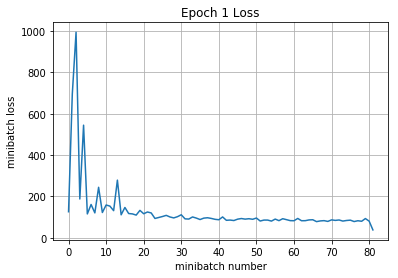

Validation
Epoch 1, Overall loss = 2.25 and accuracy of 0.562
HYPERPARAMETERS:  (0.9, 0.001, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 1.91 and accuracy of 0.42
Epoch 1, Overall loss = 6.82e+03 and accuracy of 0.707


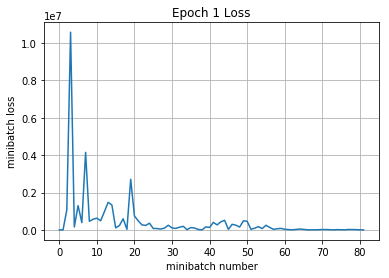

Validation
Epoch 1, Overall loss = 552 and accuracy of 0.562
HYPERPARAMETERS:  (0.9, 0.01, 1e-05, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 12.4 and accuracy of 0.78
Epoch 1, Overall loss = 12.2 and accuracy of 0.792


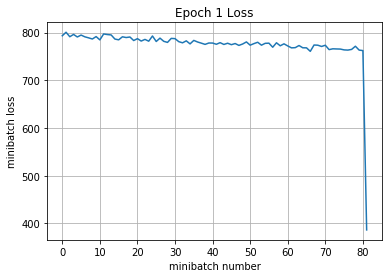

Validation
Epoch 1, Overall loss = 12.3 and accuracy of 0.625
HYPERPARAMETERS:  (0.9, 0.01, 0.001, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 12.5 and accuracy of 0.77
Epoch 1, Overall loss = 10.5 and accuracy of 0.809


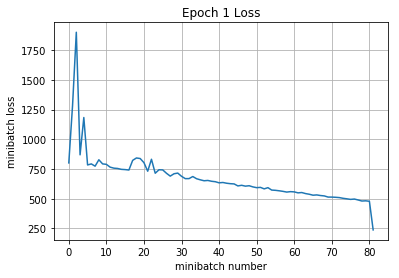

Validation
Epoch 1, Overall loss = 7.74 and accuracy of 0.75
HYPERPARAMETERS:  (0.9, 0.01, 0.01, 1000, 0.8)
Training
Iteration 0: with minibatch training loss = 12.5 and accuracy of 0.75
Epoch 1, Overall loss = 5.68e+03 and accuracy of 0.708


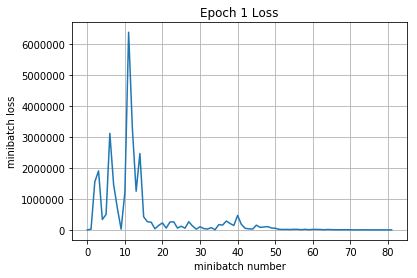

Validation
Epoch 1, Overall loss = 68.7 and accuracy of 0.625


In [35]:
L = [1e-5, 1e-3, 1e-2]
for dropout_strength in [.4, .6, .8, .9]:
    for reg in L:
        for starter_learning_rate in L:
            def my_model(X,y,is_training):
    #hyperparameters


                Wconv1 = tf.get_variable("Wconv1", shape=[2, 2, 1, 10])
                bconv1 = tf.get_variable("bconv1", shape=[10])
                betabatch1 = tf.get_variable("betabatch", shape = [10])
                gammabatch1 = tf.get_variable("gammabatch", shape = [10])

                Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 10, 60])
                bconv2 = tf.get_variable("bconv2", shape=[60])
                betabatch2 = tf.get_variable("betabatch2", shape = [60])
                gammabatch2 = tf.get_variable("gammabatch2", shape = [60])

                Wconv3 = tf.get_variable("Wconv3", shape=[5, 5, 60, 70])
                bconv3 = tf.get_variable("bconv3", shape=[70])

                Wconv4 = tf.get_variable("Wconv4", shape=[3, 3, 70, 80])
                bconv4 = tf.get_variable("bconv4", shape=[80])

                Wconv5 = tf.get_variable("Wconv5", shape=[3, 3, 80, 90])
                bconv5 = tf.get_variable("bconv5", shape=[90])


                W6 = tf.get_variable("W6", shape=[6*6*90, 800])
                b6 = tf.get_variable("b6", shape=[800])
                W7 = tf.get_variable("W7", shape=[800,900])
                b7 = tf.get_variable("b7", shape=[900])
                W8 = tf.get_variable("W8", shape=[900,2])
                b8 = tf.get_variable("b8", shape=[2])

                ### CONV1 ###

                conv1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
                relu1 = tf.nn.relu(conv1)
                relu1 = tf.nn.dropout(relu1, dropout_strength)
                mpool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID' )
                meanbatch1, variancebatch1 = tf.nn.moments(mpool1, axes = [0,1,2], keep_dims=True)
                norm1 = tf.nn.batch_normalization(mpool1, meanbatch1, variancebatch1, betabatch1, gammabatch1, 1e-5)

                ### CONV2 ###

                conv2 = tf.nn.conv2d(norm1, Wconv2, strides=[1,1,1,1], padding='SAME') + bconv2
                relu2 = tf.nn.relu(conv2)
                relu2 = tf.nn.dropout(relu2, dropout_strength)
                mpool2 = tf.nn.max_pool(relu2, ksize=[1, 4, 4, 1], strides=[1, 1, 1, 1], padding='VALID' )
                meanbatch2, variancebatch2 = tf.nn.moments(mpool2, axes = [0,1,2], keep_dims=True)
                norm2 = tf.nn.batch_normalization(mpool2, meanbatch2, variancebatch2, betabatch2, gammabatch2, 1e-5)

                ### CONV3 ###
                # Padding
            #     paddings = tf.constant()
            #     norm2 = tf.pad(norm2, paddings, "CONSTANT")
                norm2 = tf.image.resize_image_with_crop_or_pad(
                norm2,
                29,
                29
            )
                conv3 = tf.nn.conv2d(norm2, Wconv3, strides=[1,2,2,1], padding='VALID') + bconv3
                conv4 = tf.nn.conv2d(conv3, Wconv4, strides=[1,1,1,1], padding='SAME') + bconv4
                conv5 = tf.nn.conv2d(conv4, Wconv5, strides=[1,1,1,1], padding='SAME') + bconv5
                mpool3 = tf.nn.max_pool(conv5, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID' )

                ### FC6, FC7, FC8 ###
                mpool3_flat = tf.reshape(mpool3,[-1,6*6*90])
                fc6 = tf.matmul(mpool3_flat,W6) + b6
                fc7 = tf.matmul(fc6,W7) + b7
                y_out = tf.matmul(fc7,W8) + b8
                regularizers = (tf.nn.l2_loss(Wconv1) + tf.nn.l2_loss(Wconv2) + tf.nn.l2_loss(Wconv3) +  tf.nn.l2_loss(Wconv4) +\
                            tf.nn.l2_loss(Wconv5) + tf.nn.l2_loss(W6) + tf.nn.l2_loss(W7) + tf.nn.l2_loss(W8))
                return y_out, regularizers
            # hyperparameters
#             reg = 1e-3
#             starter_learning_rate = 5e-2
#             decay_steps = 1000
#             decay_rate = 0.8
            tf.reset_default_graph()

            X = tf.placeholder(tf.float32, [None, 32, 32, 1])
            y = tf.placeholder(tf.int64, [None])
            is_training = tf.placeholder(tf.bool)

            y_out, regularizers = my_model(X,y,is_training)

            # loss function with L2 regularization
            total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,2),logits=y_out)
            mean_loss = tf.reduce_mean(total_loss)
            mean_loss = tf.reduce_mean(mean_loss + reg * regularizers)

            # define our optimizer

            global_step = tf.Variable(0, trainable=False)
            learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                                       decay_steps, decay_rate, staircase=True)
            optimizer = tf.train.AdamOptimizer(learning_rate) # select optimizer and set learning rate

            # batch normalization in tensorflow requires this extra dependency
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(extra_update_ops):
                train_step = optimizer.minimize(mean_loss)
                
            print('HYPERPARAMETERS: ', (dropout_strength, reg, starter_learning_rate, decay_steps, decay_rate))
            sess = tf.Session()

            sess.run(tf.global_variables_initializer())
            print('Training')
            run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
            print('Validation')
            run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
                
                
                
                

In [33]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,15,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training


ValueError: Cannot feed value of shape (64, 32, 32, 1) for Tensor 'Placeholder:0', which has shape '(?, 32, 32, 3)'

In [ ]:
 (0.6, 1e-05, 0.001, 1000, 0.8) 93.8

Training
Iteration 0: with minibatch training loss = 0.911 and accuracy of 0.23
Epoch 1, Overall loss = 0.733 and accuracy of 0.838


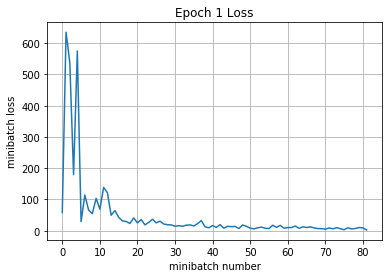

Iteration 100: with minibatch training loss = 0.0637 and accuracy of 0.97
Epoch 2, Overall loss = 0.125 and accuracy of 0.958


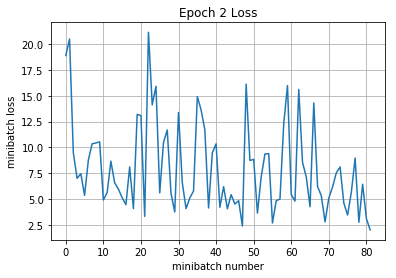

Iteration 200: with minibatch training loss = 0.118 and accuracy of 0.95
Epoch 3, Overall loss = 0.0868 and accuracy of 0.972


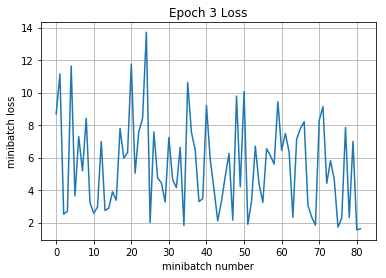

Iteration 300: with minibatch training loss = 0.067 and accuracy of 0.98
Epoch 4, Overall loss = 0.0709 and accuracy of 0.976


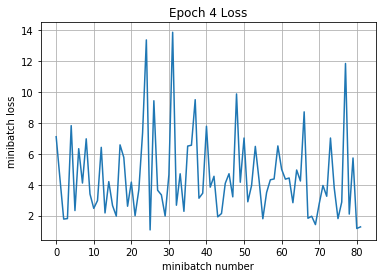

Iteration 400: with minibatch training loss = 0.0239 and accuracy of 1
Epoch 5, Overall loss = 0.0621 and accuracy of 0.98


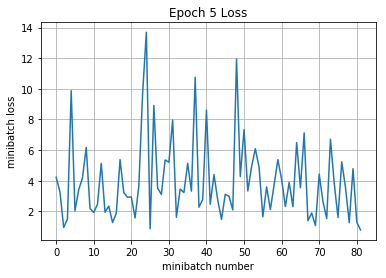

Epoch 6, Overall loss = 0.0587 and accuracy of 0.983


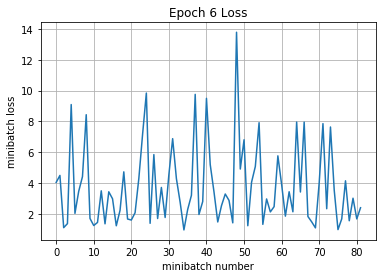

Iteration 500: with minibatch training loss = 0.0785 and accuracy of 0.95
Epoch 7, Overall loss = 0.0647 and accuracy of 0.98


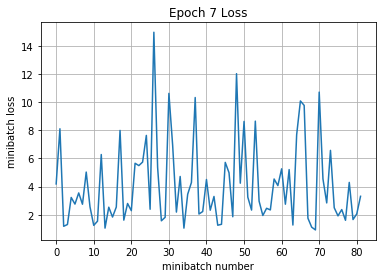

Iteration 600: with minibatch training loss = 0.0417 and accuracy of 0.98
Epoch 8, Overall loss = 0.0568 and accuracy of 0.982


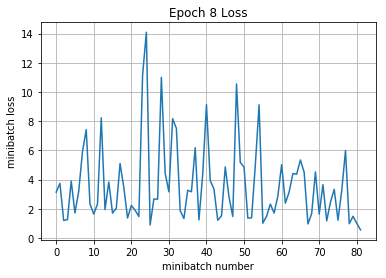

Iteration 700: with minibatch training loss = 0.0837 and accuracy of 0.97
Epoch 9, Overall loss = 0.0664 and accuracy of 0.979


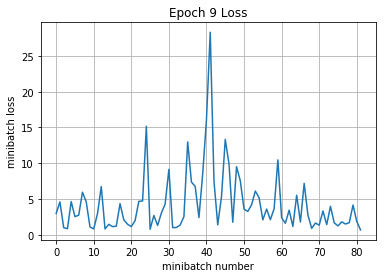

Iteration 800: with minibatch training loss = 0.0251 and accuracy of 1
Epoch 10, Overall loss = 0.0664 and accuracy of 0.981


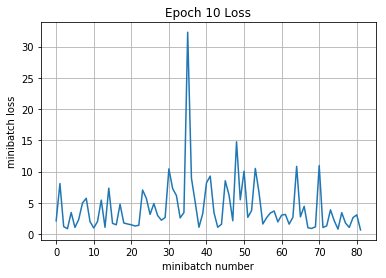

Iteration 900: with minibatch training loss = 0.0627 and accuracy of 0.97
Epoch 11, Overall loss = 0.0542 and accuracy of 0.983


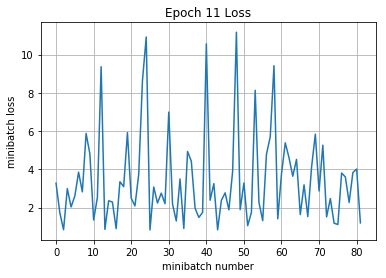

Epoch 12, Overall loss = 0.0595 and accuracy of 0.981


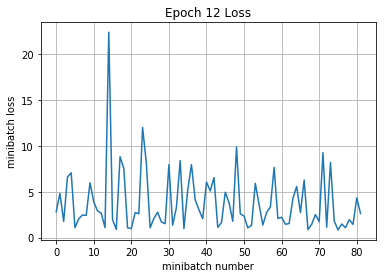

Iteration 1000: with minibatch training loss = 0.0869 and accuracy of 0.95
Epoch 13, Overall loss = 0.0495 and accuracy of 0.987


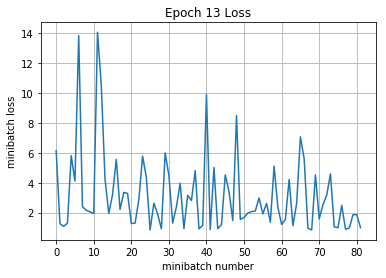

Iteration 1100: with minibatch training loss = 0.0171 and accuracy of 1
Epoch 14, Overall loss = 0.0551 and accuracy of 0.983


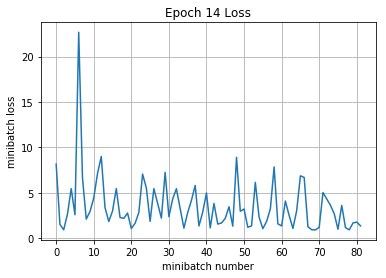

Iteration 1200: with minibatch training loss = 0.0183 and accuracy of 1
Epoch 15, Overall loss = 0.0378 and accuracy of 0.99


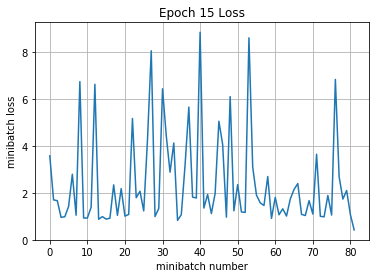

Validation
Epoch 1, Overall loss = 0.0487 and accuracy of 1


(0.04871125519275665, 1.0)

In [37]:
def my_model(X,y,is_training):
    #hyperparameters


    Wconv1 = tf.get_variable("Wconv1", shape=[2, 2, 1, 10])
    bconv1 = tf.get_variable("bconv1", shape=[10])
    betabatch1 = tf.get_variable("betabatch", shape = [10])
    gammabatch1 = tf.get_variable("gammabatch", shape = [10])

    Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 10, 60])
    bconv2 = tf.get_variable("bconv2", shape=[60])
    betabatch2 = tf.get_variable("betabatch2", shape = [60])
    gammabatch2 = tf.get_variable("gammabatch2", shape = [60])

    Wconv3 = tf.get_variable("Wconv3", shape=[5, 5, 60, 70])
    bconv3 = tf.get_variable("bconv3", shape=[70])

    Wconv4 = tf.get_variable("Wconv4", shape=[3, 3, 70, 80])
    bconv4 = tf.get_variable("bconv4", shape=[80])

    Wconv5 = tf.get_variable("Wconv5", shape=[3, 3, 80, 90])
    bconv5 = tf.get_variable("bconv5", shape=[90])


    W6 = tf.get_variable("W6", shape=[6*6*90, 800])
    b6 = tf.get_variable("b6", shape=[800])
    W7 = tf.get_variable("W7", shape=[800,900])
    b7 = tf.get_variable("b7", shape=[900])
    W8 = tf.get_variable("W8", shape=[900,2])
    b8 = tf.get_variable("b8", shape=[2])

    ### CONV1 ###

    conv1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
    relu1 = tf.nn.relu(conv1)
    relu1 = tf.nn.dropout(relu1, dropout_strength)
    mpool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID' )
    meanbatch1, variancebatch1 = tf.nn.moments(mpool1, axes = [0,1,2], keep_dims=True)
    norm1 = tf.nn.batch_normalization(mpool1, meanbatch1, variancebatch1, betabatch1, gammabatch1, 1e-5)

    ### CONV2 ###

    conv2 = tf.nn.conv2d(norm1, Wconv2, strides=[1,1,1,1], padding='SAME') + bconv2
    relu2 = tf.nn.relu(conv2)
    relu2 = tf.nn.dropout(relu2, dropout_strength)
    mpool2 = tf.nn.max_pool(relu2, ksize=[1, 4, 4, 1], strides=[1, 1, 1, 1], padding='VALID' )
    meanbatch2, variancebatch2 = tf.nn.moments(mpool2, axes = [0,1,2], keep_dims=True)
    norm2 = tf.nn.batch_normalization(mpool2, meanbatch2, variancebatch2, betabatch2, gammabatch2, 1e-5)

    ### CONV3 ###
    # Padding
    #     paddings = tf.constant()
    #     norm2 = tf.pad(norm2, paddings, "CONSTANT")
    norm2 = tf.image.resize_image_with_crop_or_pad(
    norm2,
    29,
    29
    )
    conv3 = tf.nn.conv2d(norm2, Wconv3, strides=[1,2,2,1], padding='VALID') + bconv3
    conv4 = tf.nn.conv2d(conv3, Wconv4, strides=[1,1,1,1], padding='SAME') + bconv4
    conv5 = tf.nn.conv2d(conv4, Wconv5, strides=[1,1,1,1], padding='SAME') + bconv5
    mpool3 = tf.nn.max_pool(conv5, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID' )

    ### FC6, FC7, FC8 ###
    mpool3_flat = tf.reshape(mpool3,[-1,6*6*90])
    fc6 = tf.matmul(mpool3_flat,W6) + b6
    fc7 = tf.matmul(fc6,W7) + b7
    y_out = tf.matmul(fc7,W8) + b8
    regularizers = (tf.nn.l2_loss(Wconv1) + tf.nn.l2_loss(Wconv2) + tf.nn.l2_loss(Wconv3) +  tf.nn.l2_loss(Wconv4) +\
                tf.nn.l2_loss(Wconv5) + tf.nn.l2_loss(W6) + tf.nn.l2_loss(W7) + tf.nn.l2_loss(W8))
    return y_out, regularizers
            # hyperparameters
#             reg = 1e-3
#             starter_learning_rate = 5e-2
#             decay_steps = 1000
#             decay_rate = 0.8

reg = 1e-5
starter_learning_rate = .001
decay_steps = 1000
decay_rate = 0.8
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 1])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out, regularizers = my_model(X,y,is_training)

# loss function with L2 regularization
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,2),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)
mean_loss = tf.reduce_mean(mean_loss + reg * regularizers)

# define our optimizer

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate) # select optimizer and set learning rate

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,15,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)